In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import time
import math

# Parameters
learning_rate = 0.001
training_epochs = 30 #15
batch_size = 100
display_step = 1

In [3]:
import csv
import os
import numpy as np

#인코딩중요
#라벨만들기
with open('./trainSet.csv', 'r', encoding='UTF-8-sig') as raw:
    lines = raw.readlines()
data = list(csv.reader(lines))
data = sorted(data, key=lambda x: x[0])

#이름빼기
_Y = [y[1] for y in data]

_Y = np.array(_Y)
_Y = _Y.astype(float) # shape(-1)
_Y = [[1-y, y] for y in _Y] # shape(-1, 2)


#데이터만들기
with open('./features4096.csv', 'r', encoding='UTF-8-sig') as raw:
    lines = raw.readlines()
data = list(csv.reader(lines))
data = sorted(data, key=lambda x: x[0])

#이름빼기
_X = [x[1:] for x in data]

_X = np.array(_X)
_X = _X.astype(float) # shape(-1, 1024)

train_X = _X[:8000]
train_Y = _Y[:8000]
test_X = _X[8000:]
test_Y = _Y[8000:]

train_set = tuple(zip(train_X, train_Y))
test_set = tuple(zip(test_X, test_Y))

M_test_X = [t[0] for t in test_set if t[1][1] == 1] # label의 악성이면 # 1423
M_test_Y = [t[1] for t in test_set if t[1][1] == 1] # label의 악성이면 # 1423

N_test_X = [t[0] for t in test_set if t[1][0] == 1] # label의 정상이면 # 577
N_test_Y = [t[1] for t in test_set if t[1][0] == 1] # label의 정상이면 # 577



In [4]:
with tf.device('/gpu:0'):
    X = tf.placeholder(tf.float32, [None, 4096])
    X_img = tf.reshape(X, [-1, 64, 64, 1]) # img 28x28x1 (black/white)
    Y = tf.placeholder(tf.float32, [None, 2])
    keep_prob = tf.placeholder(tf.float32)

    #X_img = tf.nn.dropout(X_img, keep_prob=keep_prob)


    # L1 ImgIn shape=(?, 64, 64, 1)
    W1 = tf.Variable(tf.random_normal([4, 4, 1, 64], stddev=0.01))
    L1 = tf.nn.conv2d(X_img, W1, strides=[1,1,1,1], padding='SAME')
    L1 = tf.nn.relu(L1)
    L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
    #    Conv    -> (?, 64, 64, 64)
    #    Pool    -> (?, 32, 32, 64)


    # L2 ImgIn shape=(?, 32, 32, 64)
    W2 = tf.Variable(tf.random_normal([4, 4, 64, 128], stddev=0.01))
    L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding='SAME')
    L2 = tf.nn.relu(L2)
    L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
    #    Conv    -> (?, 32, 32, 128)
    #    Pool    -> (?, 16, 16, 128)


    # L3 ImgIn shape=(?, 16, 16, 128)
    W3 = tf.Variable(tf.random_normal([4, 4, 128, 256], stddev=0.01))
    L3 = tf.nn.conv2d(L2, W3, strides=[1,1,1,1], padding='SAME')
    L3 = tf.nn.relu(L3)
    L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    L3 = tf.reshape(L3, [-1, 8 * 8 * 256])
    L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
    #    Conv    -> (?, 16, 16, 256)
    #    Pool    -> (?, 8, 8, 256)
    #    Pool    -> (?, 8192)
    

    W4 = tf.get_variable('W4', shape=[8*8*256, 2], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.random_normal([2]))
    hypothesis = tf.matmul(L3, W4) + b


    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
# Training
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#sess.run(tf.initialize_all_variables())

# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = math.ceil(len(train_X) / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = train_X[i*100:(i+1)*100], train_Y[i*100:(i+1)*100]
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        #feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        
        avg_cost += c / total_batch #뭉치갯수로 나누기
        time.sleep(0.15)
        
        
    print('Epoch : ', '%04d' % (epoch + 1), 'cost = ', '{:.9f}'.format(avg_cost))


Epoch :  0001 cost =  0.595054605
Epoch :  0002 cost =  0.525885185
Epoch :  0003 cost =  0.484376267
Epoch :  0004 cost =  0.449131006
Epoch :  0005 cost =  0.406900357
Epoch :  0006 cost =  0.364106827
Epoch :  0007 cost =  0.330056524
Epoch :  0008 cost =  0.304222585
Epoch :  0009 cost =  0.272749956
Epoch :  0010 cost =  0.260225612
Epoch :  0011 cost =  0.236818656
Epoch :  0012 cost =  0.221175214
Epoch :  0013 cost =  0.213927176
Epoch :  0014 cost =  0.187627375
Epoch :  0015 cost =  0.176043259
Epoch :  0016 cost =  0.179838600
Epoch :  0017 cost =  0.169861730
Epoch :  0018 cost =  0.152689974
Epoch :  0019 cost =  0.147646004
Epoch :  0020 cost =  0.142336344
Epoch :  0021 cost =  0.132333270
Epoch :  0022 cost =  0.129544692
Epoch :  0023 cost =  0.129010010
Epoch :  0024 cost =  0.115524817
Epoch :  0025 cost =  0.116782758
Epoch :  0026 cost =  0.115768036
Epoch :  0027 cost =  0.107981528
Epoch :  0028 cost =  0.101514674
Epoch :  0029 cost =  0.102525345
Epoch :  0030 

Accuracy : 0.9240
정탐율 : 0.9831
오탐율 : 0.7782
Label: [0]
Prediction: [0]


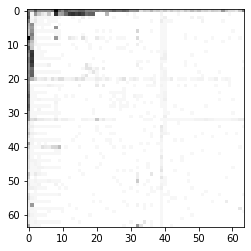

In [20]:
# TEST
is_correct = tf.equal(tf.arg_max(hypothesis, 1), tf.arg_max(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

#메모리한계때문에 에러나는듯
#feed_dict = {X: test_X[:1000], Y: test_Y[:1000], keep_prob: 1}
#print("Accuracy : ", accuracy.eval(session=sess, feed_dict=feed_dict))

#feed_dict = {X: M_test_X, Y: M_test_Y, keep_prob: 1}
#print("정탐율 : ", accuracy.eval(session=sess, feed_dict=feed_dict))

#feed_dict = {X: N_test_X, Y: N_test_Y, keep_prob: 1}
#print("오탐율 : ", accuracy.eval(session=sess, feed_dict=feed_dict))


total_batch = math.ceil(len(test_X) / batch_size)
total_acc = 0
for i in range(total_batch):
    batch_xs, batch_ys = test_X[i*100:(i+1)*100], test_Y[i*100:(i+1)*100]
    feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 1}
    one_acc = accuracy.eval(session=sess, feed_dict=feed_dict)
    total_acc += one_acc * len(batch_ys)
print("Accuracy : %0.4f"%(total_acc/len(test_Y)))


total_batch = math.ceil(len(M_test_X) / batch_size)
total_acc = 0
for i in range(total_batch):
    batch_xs, batch_ys = M_test_X[i*100:(i+1)*100], M_test_Y[i*100:(i+1)*100]
    feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 1}
    one_acc = accuracy.eval(session=sess, feed_dict=feed_dict)
    total_acc += one_acc * len(batch_ys)
print("정탐율 : %0.4f"%(total_acc/len(M_test_Y)))


total_batch = math.ceil(len(N_test_X) / batch_size)
total_acc = 0
for i in range(total_batch):
    batch_xs, batch_ys = N_test_X[i*100:(i+1)*100], N_test_Y[i*100:(i+1)*100]
    feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 1}
    one_acc = accuracy.eval(session=sess, feed_dict=feed_dict)
    total_acc += one_acc * len(batch_ys)
print("오탐율 : %0.4f"%(total_acc/len(N_test_Y)))



r = random.randint(0, len(test_X) - 1)
print('Label:', sess.run(tf.argmax(test_Y[r:r+1], 1)))

feed_dict = {X: test_X[r:r+1], keep_prob: 1}
print('Prediction:', sess.run(tf.argmax(hypothesis, 1), feed_dict=feed_dict))

plt.imshow(test_X[r:r+1].reshape(64, 64), cmap='Greys', interpolation='nearest')
plt.show()